# Prediction based on Meta-Information

## Import

In [2]:
import os

try:
    from google.colab import drive
    drive_dir = '/content/drive'
    drive.mount(drive_dir)
    root_dir = '/content/drive/My Drive/AML/'
    git_dir = root_dir+'Git/'
    COLAB_IN = True
except:
    COLAB_IN = False

if COLAB_IN:
    os.chdir("drive/My Drive/AML/Git_lastClone/neural-network/metadata_model")
    !pip install livelossplot
    !pip install imdbpy
    !pip install youtube_dl
    !pip install keras_tqdm


import numpy as np
import tensorflow as tf
import json
import functools
import itertools
import numpy
import operator
from keras.utils import to_categorical
import urllib.parse
import urllib.request
import requests
import youtube_dl
import imdb
from tqdm import tnrange, tqdm_notebook
import sys
from bs4 import BeautifulSoup
import math
from time import time
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization, Activation
from keras.backend.tensorflow_backend import set_session
import matplotlib.pyplot as plt
from livelossplot import PlotLossesKeras
import random
from sklearn.decomposition import TruncatedSVD
import pickle
from keras_tqdm import TQDMNotebookCallback

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Using TensorFlow backend.


## Utility functions

In [0]:
_WARNINGS = False

def urlopen(url, mobile = False):
    try:
        if mobile:
            urlheader =  {'User-Agent': 'Mozilla/5.0 (iPhone; CPU iPhone OS 5_0 like Mac OS X) AppleWebKit/534.46' ,
            'Accept': 'text/html,application/xhtml+xml,application/xml;q=0.9,*/*;q=0.8',
            'Accept-Charset': 'ISO-8859-1,utf-8;q=0.7,*;q=0.3',
            'Accept-Encoding': 'none',
            'Accept-Language': 'en-US,en;q=0.8',
            'Connection': 'keep-alive'}
        else:
            urlheader = {'User-Agent': 'Mozilla/5.0 (X11; Linux x86_64) ' 
                          'AppleWebKit/537.11 (KHTML, like Gecko) '
                          'Chrome/23.0.1271.64 Safari/537.11',
            'Accept': 'text/html,application/xhtml+xml,application/xml;q=0.9,*/*;q=0.8',
            'Accept-Charset': 'ISO-8859-1,utf-8;q=0.7,*;q=0.3',
            'Accept-Encoding': 'none',
            'Accept-Language': 'en-US,en;q=0.8',
            'Connection': 'keep-alive'
                        }
        #header2 = 'Mozilla/5.0 (X11; Linux i686) AppleWebKit/537.17 (KHTML, like Gecko) Chrome/24.0.1312.27 Safari/537.17'
        return urllib.request.urlopen(urllib.request.Request(url=url, data=None, headers=urlheader)).read().decode('utf-8')
    except HTTPError as e:
        if (_WARNINGS):
            time.sleep(5);
            warnings.warn(str(e))
            return urlopen(url)
        else:
            raise e

## Dataset

### Loader and encoder

In [0]:
class DatasetLoader():
    def __init__(self):
        self.Youtube_urlroot = "https://www.youtube.com"
        self.Imdb_urlroot = "https://www.imdb.com"
        pass
    
    def Load(self, filename, dataset_dir):
        self.filename = filename
        # go to repository
        with open(os.path.join(dataset_dir, filename+'.json'), "r+") as jsonFile:
            self.data = json.load(jsonFile)
            jsonFile.seek(0)  # rewind
            json.dump(self.data, jsonFile)
            jsonFile.truncate()
        # filter english movies only
        self.data = [item for id, item in self.data.items() if 'United Kingdom' in item['boxOffice']['country'] or  'United States' in item['boxOffice']['country']]
        # get size
        self.size = len(self.data)
    
    def ExtractMetaInfo(self):
        
        # extract name
        self.name = [item['name'] for item in self.data]
        
        # extract revenue first week
        self.week1_rev_uncoded = np.array([item['boxOffice']['revenue_week1'] for item in self.data])
        
        ############################################## LABELING ################################################
        self.num_classes = 200 # Number of classes
        
        # non linear labeling
        quantiles = np.linspace(1/self.num_classes, 1, self.num_classes)
        self.class_limits = [0]
        for q in quantiles:
            self.class_limits.append(np.quantile(np.array(self.week1_rev_uncoded), q))
        self.class_limits = np.array(self.class_limits)
    
        self.labels = np.sum(self.class_limits.reshape(self.class_limits.size, 1) < self.week1_rev_uncoded, 0) - 1
        
        # encode
        self.revenue_week1 = []
        for i in range(self.week1_rev_uncoded.size):
            tmp = np.zeros(self.num_classes)
            tmp[self.labels[i]] = 1.
            self.revenue_week1.append(tmp)
        self.revenue_week1 = np.array(self.revenue_week1)
        #########################################################################################################
        
        
        # extract and code genres
        all_genres_label = list(set(functools.reduce(operator.iconcat,[([genre for genre in item['genre']] if isinstance(item['genre'], list) else [item['genre']]) if 'genre' in item.keys() else [] for item in self.data], [])))
        all_genres_ohc = to_categorical(range(len(all_genres_label)))
        self.all_genres = dict(zip(all_genres_label, all_genres_ohc))
        self.genres = []
        for item in self.data:
            genres_coded = np.zeros(len(self.all_genres),)
            if "genre" in item.keys():
                for x in item["genre"]:
                    try:
                        genres_coded += self.all_genres[x]
                    except: #unknown
                        pass
            self.genres.append(genres_coded)
        
        # extract and code contentRating
        all_contentRating_label = list(set(functools.reduce(operator.iconcat,[([contentRating for contentRating in item['contentRating']] if isinstance(item['contentRating'], list)
                                                                               else [item['contentRating']]) if 'contentRating' in item.keys() else [] for item in self.data], [])))
        all_contentRating_ohc = to_categorical(range(len(all_contentRating_label)))
        self.all_contentRating = dict(zip(all_contentRating_label, all_contentRating_ohc))
        print(self.all_contentRating)
        self.contentRating = []
        for item in self.data:
            contentRating_coded = np.zeros(len(self.all_contentRating),)
            try:
                contentRating_coded += self.all_contentRating[item["contentRating"]]
            except: #unknown
                pass
            self.contentRating.append(contentRating_coded)
        
      
        # extract year
        self.year = [item['boxOffice']['year'] for item in self.data]
        min_year = min(self.year)
        self.year = [((item-min_year)/(2019-min_year)) for item in self.year]
        
        # extract and code actors
        all_actors_label = list(set(functools.reduce(operator.iconcat,[([actor.get('name') for actor in item['actor']] if isinstance(item['actor'], list) else [item['actor'].get('name')]) if 'actor' in item.keys() else [] for item in self.data], [])))
        all_actors_ohc = to_categorical(range(len(all_actors_label)))
        self.all_actors= dict(zip(all_actors_label, all_actors_ohc))
        self.actors = []
        for item in self.data:
            actors_coded = np.zeros(len(self.all_actors),)
            if "actor" in item.keys():
                for x in item["actor"]:
                    try:
                        actors_coded += self.all_actors[x["name"]]
                    except: #unknown
                        pass
            self.actors.append(actors_coded)
            
        
        # extract and code directors
        all_directors_label = list(set(functools.reduce(operator.iconcat,[([director.get('name') for director in item['director']] if isinstance(item['director'], list) else [item['director'].get('name')]) if 'director' in item.keys() else [] for item in self.data], [])))
        all_directors_ohc = to_categorical(range(len(all_directors_label)))
        self.all_directors= dict(zip(all_directors_label, all_directors_ohc))
        self.directors = []
        for item in self.data:
            directors_coded = np.zeros(len(self.all_directors),)
            try:
                directors_coded += self.all_directors[item["director"]["name"]]
            except: #unknown
                pass
            self.directors.append(directors_coded)

        
        # extract and code creators
        all_creators_label = list(set(functools.reduce(operator.iconcat,[([creator.get('name') for creator in item['creator']] if isinstance(item['creator'], list) else [item['creator'].get('name')]) if 'creator' in item.keys() else [] for item in self.data], [])))
        all_creators_ohc = to_categorical(range(len(all_creators_label)))
        self.all_creators= dict(zip(all_creators_label, all_creators_ohc))
        self.creators = []
        for item in self.data:
            creators_coded = np.zeros(len(self.all_creators),)
            if "creator" in item.keys():
                for x in item["creator"]:
                    try:
                        creators_coded += self.all_creators[x["name"]]
                    except: #unknown
                        pass
            self.creators.append(creators_coded)
        
        # extract duration
        self.duration = {}
        for id, item in enumerate(self.data):
            if 'duration' in item.keys():
                hours, minutes = 0,0
                if 'H' in item['duration'] and 'M' in item['duration']:
                    hours = int(item['duration'][item['duration'].index('PT')+2:item['duration'].index('H')])
                    minutes = int(item['duration'][item['duration'].index('H')+1:item['duration'].index('M')])
                if 'H' in item['duration']:
                    hours = int(item['duration'][item['duration'].index('PT')+2:item['duration'].index('H')])
                elif 'M' in item['duration']:
                    minutes = int(item['duration'][item['duration'].index('PT')+2:item['duration'].index('M')])
                self.duration[id] = [(60 * hours) + minutes, ]
            else:
                self.duration[id]= [1, ]
        self.duration = list(self.duration.values())
        max_duration = max(self.duration)[0]
        self.duration = [(item[0] / max_duration) for item in self.duration]
        
        print('Saving coding data to binary file ...')
        if not os.path.exists('encoding'):
            os.makedirs('encoding')
            with open('encoding/encoding.pkl', 'wb') as f:
                pickle.dump([self.all_actors, self.all_directors, self.all_creators, self.all_genres, self.all_contentRating, min_year, max_duration, self.class_limits], f, protocol=pickle.HIGHEST_PROTOCOL)
        
        print('... Done matadata extraction and coding')      

In [6]:
# Load dataset
movies = DatasetLoader()
movies.Load("Dataset", dataset_dir = '../dataset')

# Extract and preprocess raw Data
movies.ExtractMetaInfo()

{'TV-Y': array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
      dtype=float32), 'TV-PG': array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
      dtype=float32), 'PG-13': array([0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
      dtype=float32), 'M/PG': array([0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
      dtype=float32), 'Passed': array([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
      dtype=float32), 'R': array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
      dtype=float32), 'Unrated': array([0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
      dtype=float32), 'Not Rated': array([0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
      dtype=float32), 'TV-Y7': array([0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
      dtype=float32), 'G': array([0., 0., 0., 0., 0., 0.,

## Fitting dataset to network

### Stacking features to input vector

In [7]:
features = ['actors', 'creators', 'directors', 'genres', 'contentRating', 'year', 'duration']

# Generate input data
X_ = []
for id in range(len(movies.name)): 
    # Handle inputs
    input_single = []
    for feature in features:
        if feature == 'actors':
            code = movies.actors[id]
            code = np.array(code)#.reshape(1, -1)
            #code_reduced = svd_actors.transform(code)[0]
            input_single = np.array(input_single)
            #code_reduced= np.array(code_reduced)
            input_single = np.concatenate((input_single, code))
            #print(len(input_single))
            
        if feature == 'creators':
            code = movies.creators[id]
            code = np.array(code)#.reshape(1, -1)
            #code_reduced = svd_creators.transform(code)[0]
            input_single = np.array(input_single)
            #code_reduced= np.array(code_reduced)
            input_single = np.concatenate((input_single, code))
            #print(len(input_single))
            
        if feature == 'directors':
            code = movies.directors[id]
            code = np.array(code)#.reshape(1, -1)
            #code_reduced = svd_directors.transform(code)[0]
            input_single = np.array(input_single)
            #code_reduced= np.array(code_reduced)
            input_single = np.concatenate((input_single, code))
            #print(len(input_single))
            
        if feature == 'genres':
            code = movies.genres[id]
            code = np.array(code)#.reshape(1, -1)
            #code_reduced = svd_genres.transform(code)[0]
            input_single = np.array(input_single)
            #code_reduced= np.array(code_reduced)
            input_single = np.concatenate((input_single, code))
            #print(len(input_single))
            
        if feature == 'contentRating':
            code = np.append(input_single, movies.contentRating[id])
            input_single = np.concatenate((code, ))
            #print(len(input_single))
            
        if feature == 'year':
            input_single = np.append(input_single, movies.year[id])
            #print(len(input_single))
            
        if feature == 'duration':
            input_single = np.append(input_single, movies.duration[id])
            ##print(len(input_single))
            
    #print(len(input_single))
    X_.append(input_single)
    
    if id != 0 and (id % 500) == 0:  
        print('Processed 500 items')

print('... Done input generation.')

Processed 500 items
Processed 500 items
Processed 500 items
Processed 500 items
Processed 500 items
Processed 500 items
Processed 500 items
Processed 500 items
Processed 500 items
Processed 500 items
Processed 500 items
Processed 500 items
Processed 500 items
Processed 500 items
Processed 500 items
... Done input generation.


### Discretization of outputs

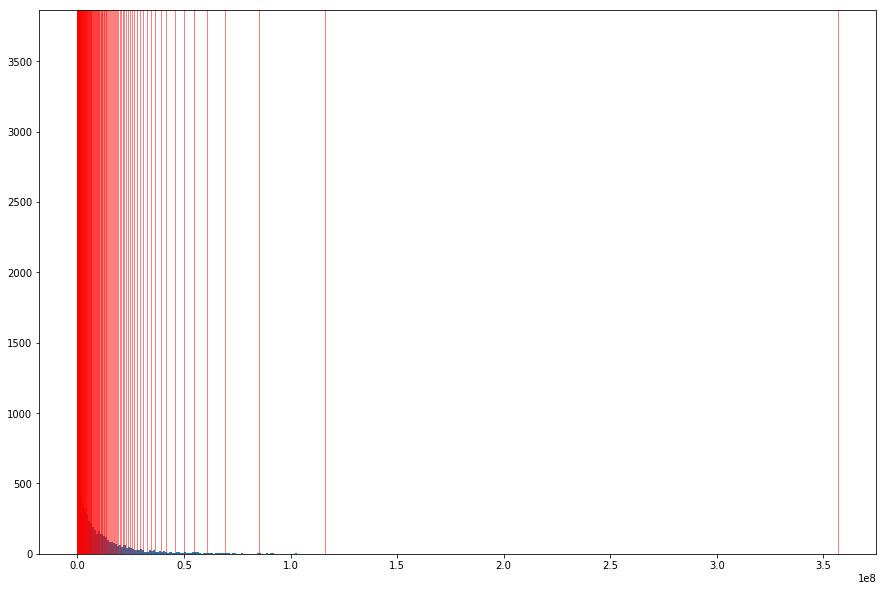

In [8]:
# display some labeling information
plt.rcParams['figure.figsize'] = 15, 10
x,bins,a = plt.hist(movies.week1_rev_uncoded,bins="auto")
for i in movies.class_limits:
    plt.axvline(i, linewidth=0.5, color='r')

### Dataset splitting (training, validation and test set)

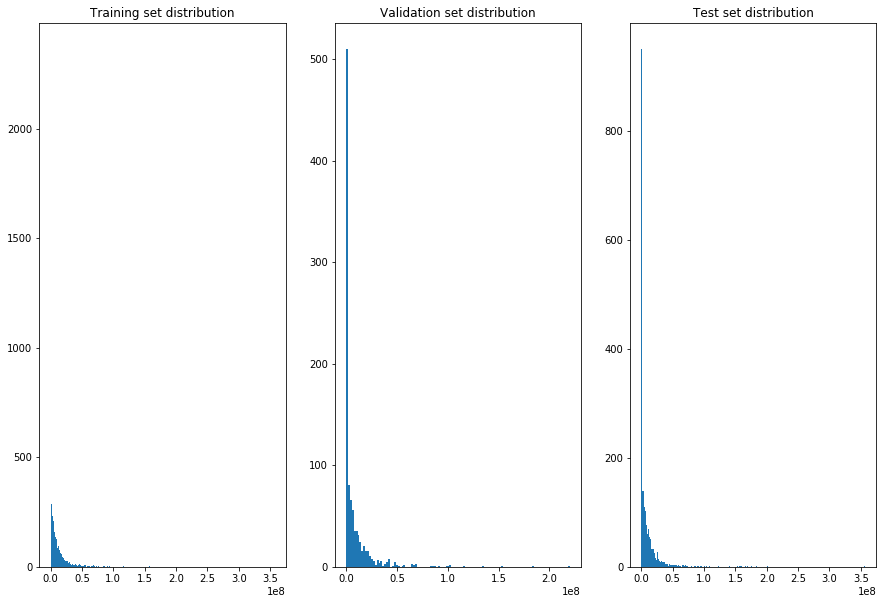

In [9]:
from sklearn.utils import shuffle
X = np.array(X_)
y = movies.revenue_week1
def getData(start, stop):
    X_, y_, y_uncoded_ = shuffle(X, y, movies.week1_rev_uncoded)
    return X_[start:stop], y_[start:stop], y_uncoded_[start:stop]
X_train, y_train, y_train_uncoded = getData(0, 5000)
X_val, y_val, y_val_uncoded = getData(5000, 6000)
X_test, y_test, y_test_uncoded =  getData(6000, -1)

# display some labeling information
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3) # two axes on figure
x,bins,a = ax1.hist(y_train_uncoded,bins="auto")
x,bins,a = ax2.hist(y_val_uncoded,bins="auto")
x,bins,a = ax3.hist(y_test_uncoded,bins="auto")
ax1.title.set_text("Training set distribution")
ax2.title.set_text('Validation set distribution')
ax3.title.set_text('Test set distribution')

## Model

### Architecture

In [10]:
model = None
model = Sequential()

# Get data/network dimensions
input_dim = len(X_[0])
output_dim = movies.num_classes
print('Network input dimension: ' + str(input_dim))
print('Network output dimension: ' + str(output_dim))

# Input layer
model.add(Dense(100, activation='relu', input_shape=(input_dim, )))
# Hidden layers
model.add(Dropout(0.5))

model.add(Dense(output_dim, activation='softmax'))
model.summary()

W0802 11:29:20.812073 139895482529664 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0802 11:29:20.834422 139895482529664 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0802 11:29:20.838371 139895482529664 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0802 11:29:20.861053 139895482529664 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:133: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W0802 11:29:20.876962 

Network input dimension: 25572
Network output dimension: 200
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 100)               2557300   
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 200)               20200     
Total params: 2,577,500
Trainable params: 2,577,500
Non-trainable params: 0
_________________________________________________________________


### Compilation

In [11]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=[ 'accuracy'])

W0802 11:29:20.941122 139895482529664 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0802 11:29:20.982693 139895482529664 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3295: The name tf.log is deprecated. Please use tf.math.log instead.



### Training & validation

W0802 11:29:21.137468 139895482529664 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 5000 samples, validate on 1000 samples
Epoch 1/20
 - 5s - loss: 5.2989 - acc: 0.0038 - val_loss: 5.2657 - val_acc: 0.0920
Epoch 2/20
 - 4s - loss: 5.2209 - acc: 0.0494 - val_loss: 5.1440 - val_acc: 0.2010
Epoch 3/20
 - 5s - loss: 4.9988 - acc: 0.1214 - val_loss: 4.9161 - val_acc: 0.3120
Epoch 4/20
 - 5s - loss: 4.6453 - acc: 0.2584 - val_loss: 4.6025 - val_acc: 0.4970
Epoch 5/20
 - 5s - loss: 4.1868 - acc: 0.4262 - val_loss: 4.2180 - val_acc: 0.5710
Epoch 6/20
 - 5s - loss: 3.6485 - acc: 0.5850 - val_loss: 3.7840 - val_acc: 0.6020
Epoch 7/20
 - 5s - loss: 3.0647 - acc: 0.6964 - val_loss: 3.3491 - val_acc: 0.6090
Epoch 8/20
 - 5s - loss: 2.4969 - acc: 0.7660 - val_loss: 2.9538 - val_acc: 0.6140
Epoch 9/20
 - 5s - loss: 1.9837 - acc: 0.8192 - val_loss: 2.6390 - val_acc: 0.6190
Epoch 10/20
 - 5s - loss: 1.5459 - acc: 0.8622 - val_loss: 2.4220 - val_acc: 0.6220
Epoch 11/20
 - 5s - loss: 1.2454 - acc: 0.8854 - val_loss: 2.2814 - val_acc: 0.6240
Epoch 12/20
 - 5s - loss: 1.0231 - ac

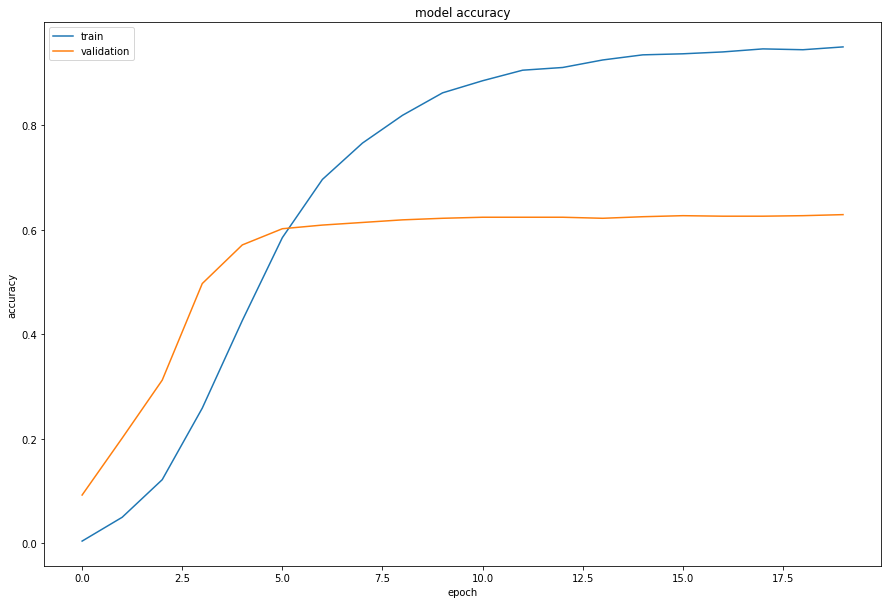

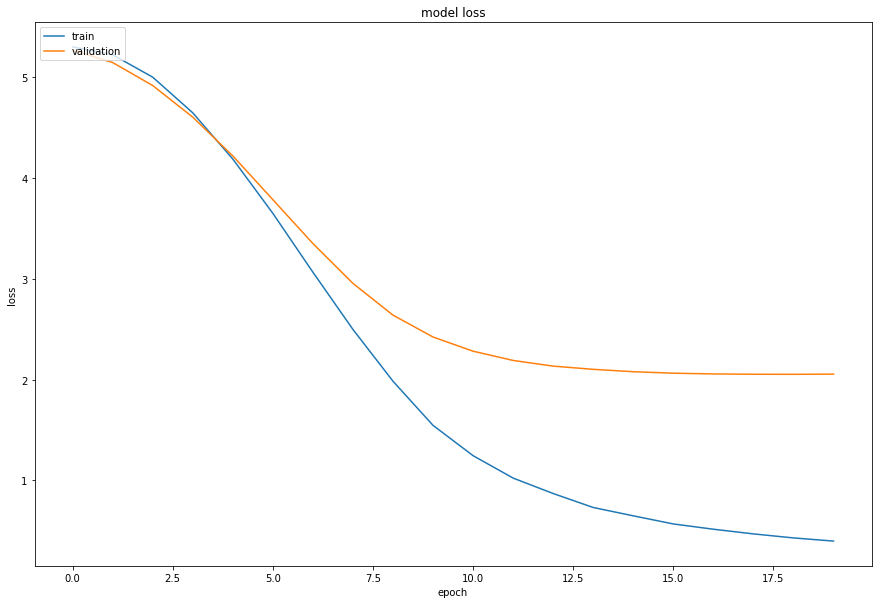

In [12]:
history = model.fit(x=X_train, y=y_train, batch_size=64, epochs=20, verbose=2,
                    validation_data=[X_val, y_val]) #callbacks=[TQDMNotebookCallback()])

# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

### Testing

In [13]:
scores = model.evaluate(X_test, y_test, verbose=0)
print(scores)

[2.225335538660854, 0.6032636410602801]


### Prediction example

In [14]:
# Test input 

test_output = model.predict(np.array([X_[0]]))
print(test_output)

index = np.argmax(test_output)
revenue = np.ceil(movies.class_limits[index] + (movies.class_limits[index+1] - movies.class_limits[index])/2)
print(revenue)

[[3.38825112e-06 1.10594510e-06 1.18520632e-06 3.60620356e-06
  4.77313279e-07 5.92549532e-06 1.10916130e-06 3.64827031e-08
  1.38415419e-06 4.23697628e-07 4.25273363e-08 2.89022523e-06
  2.03903687e-06 1.67943213e-07 7.04396768e-07 1.86550915e-06
  5.72604151e-08 5.06210597e-07 2.30223563e-07 9.53183310e-09
  8.73698070e-07 2.56816293e-07 7.22187394e-08 5.89862623e-07
  3.23924723e-05 1.42058243e-05 4.97540498e-07 3.07316850e-06
  2.15308728e-06 6.39257749e-08 2.25000190e-06 2.32483853e-06
  7.10544282e-06 4.51204897e-07 3.66756154e-08 2.92908794e-07
  1.30079491e-06 2.51187112e-06 1.50805215e-06 1.96661475e-07
  9.21110768e-06 4.24653308e-06 7.14869373e-07 4.13949419e-05
  4.57389461e-07 4.40229951e-06 3.36744097e-06 3.62864995e-07
  1.73344546e-07 2.53603753e-06 5.05624621e-06 1.20825698e-05
  1.71906052e-07 9.46037107e-05 4.59881039e-06 1.35110355e-07
  1.16390299e-06 5.53323889e-06 3.94984966e-07 9.92792764e-08
  1.10094857e-06 4.63632261e-07 3.02828016e-06 8.71953375e-07
  2.4527

### Save Model

In [0]:
# Generate directory
if not os.path.exists('trained_model'):
    os.makedirs('trained_model')
model.save('./trained_model/metadata.model')